      month  dispensings
0  1-Jan-11        16831
1  1-Feb-11        17234
2  1-Mar-11        20546
3  1-Apr-11        19226
4  1-May-11        21136


<Figure size 640x480 with 0 Axes>

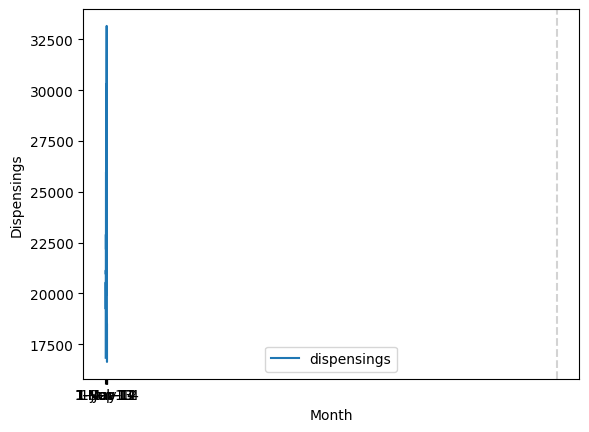

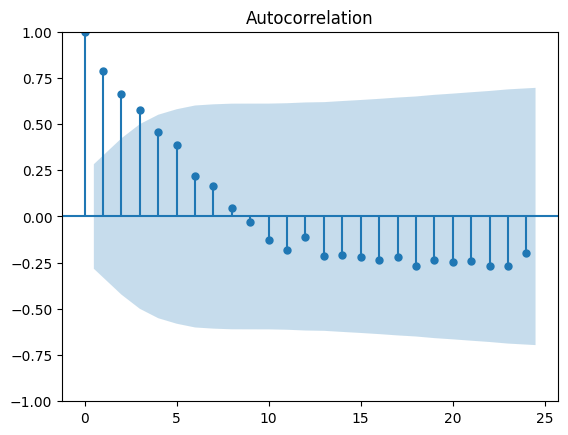

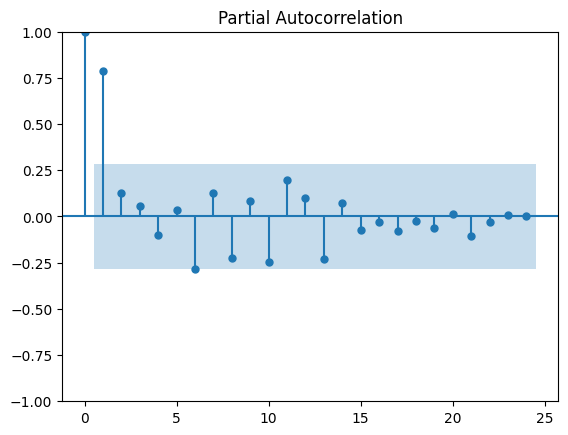

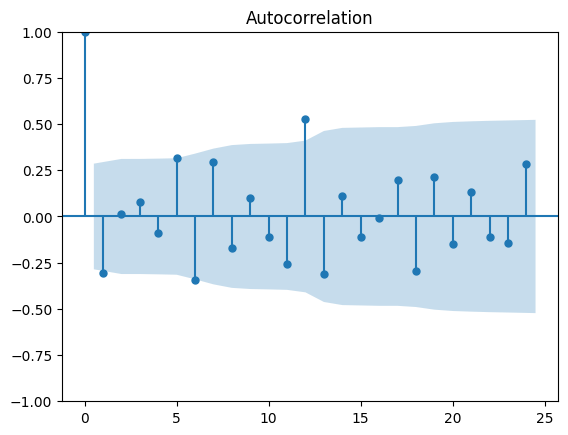

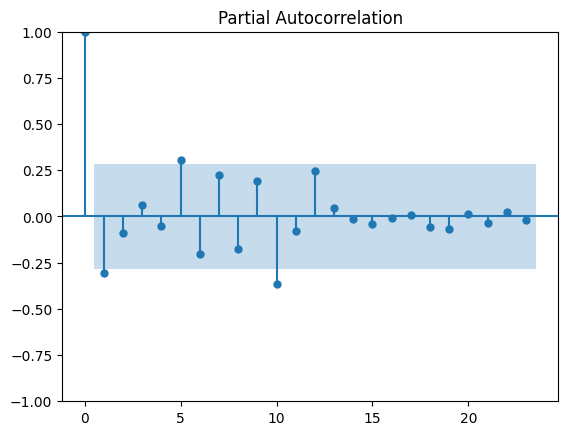

       month  dispensings  step  ramp
0 2011-01-01        16831     0     0
1 2011-02-01        17234     0     0
2 2011-03-01        20546     0     0
3 2011-04-01        19226     0     0
4 2011-05-01        21136     0     0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                        dispensings   No. Observations:                   48
Model:             ARIMA(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -308.024
Date:                            Wed, 28 Feb 2024   AIC                            624.048
Time:                                    20:02:37   BIC                            630.269
Sample:                                         0   HQIC                           626.196
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0218      0.149     -0.146      0.884      -0.314       0.270
ar.L2          0.0534      0.194   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


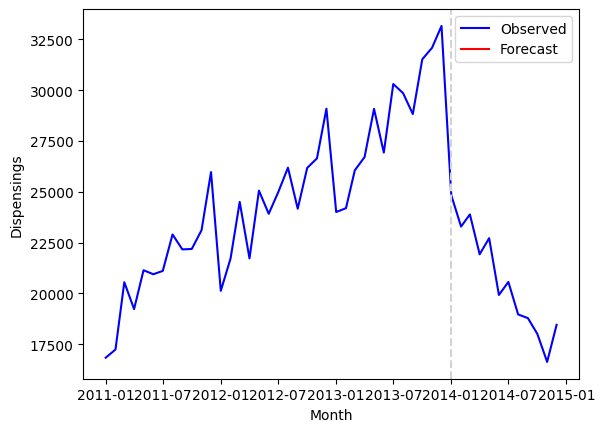

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load data
quet = pd.read_csv("quet.csv")

# View data
print(quet.head())

# Plot data to visualise time series
plt.figure()
quet.plot(x='month', y='dispensings', kind='line')
plt.axvline(pd.Timestamp('2014-01-01'), color='lightgray', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Dispensings')
plt.show()

# View ACF/PACF plots of undifferenced data
plot_acf(quet['dispensings'], lags=24)
plt.show()
plot_pacf(quet['dispensings'], lags=24)
plt.show()

# View ACF/PACF plots of differenced/seasonally differenced data
plot_acf(quet['dispensings'].diff().dropna(), lags=24)
plt.show()
diffed_data_length = len(quet['dispensings'].diff().dropna())
max_lags = diffed_data_length // 2  # Ensure lags do not exceed half of the sample size
plot_pacf(quet['dispensings'].diff().dropna(), lags=min(24, max_lags))
plt.show()

# Convert 'month' column to datetime format
quet['month'] = pd.to_datetime(quet['month'])

# Create variable representing step change and ramp and view
quet['step'] = (quet['month'] >= '2014-01-01').astype(int)
quet['ramp'] = (quet['month'] - pd.Timestamp('2013-12-01')).dt.days // 30
quet.loc[quet['month'] < '2014-01-01', 'ramp'] = 0
print(quet.head())

# Specify first difference = 1 and seasonal difference = 1
# Run model and check residuals
model = ARIMA(quet['dispensings'], order=(2,1,0), seasonal_order=(0,1,1,12))  # Changed non-seasonal MA component to 0
results = model.fit()
print(results.summary())


# Get confidence intervals
ci = results.conf_int(alpha=0.05)
print(ci)

# To forecast the counterfactual, model data excluding post-intervention time period
quet2 = quet.copy()
quet2.loc[quet2['month'] >= '2014-01-01', 'dispensings'] = np.nan

# Forecast 12 months post-intervention
model2 = ARIMA(quet2['dispensings'], order=(2,1,0), seasonal_order=(0,1,1,12))  # Changed non-seasonal MA component to 0
results2 = model2.fit()
forecast = results2.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Combine with observed data
quet3 = quet.merge(forecast.predicted_mean.rename('forecast'), left_index=True, right_index=True, how='outer')
quet3 = quet3.merge(forecast_ci, left_index=True, right_index=True, how='outer')

# Plot
plt.figure()
plt.plot(quet3['month'], quet3['dispensings'], label='Observed', color='blue')
plt.plot(quet3['month'], quet3['forecast'], label='Forecast', color='red')
plt.fill_between(quet3['month'], quet3['lower dispensings'], quet3['upper dispensings'], color='pink', alpha=0.3)
plt.axvline(pd.Timestamp('2014-01-01'), color='lightgray', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Dispensings')
plt.legend()
plt.show()

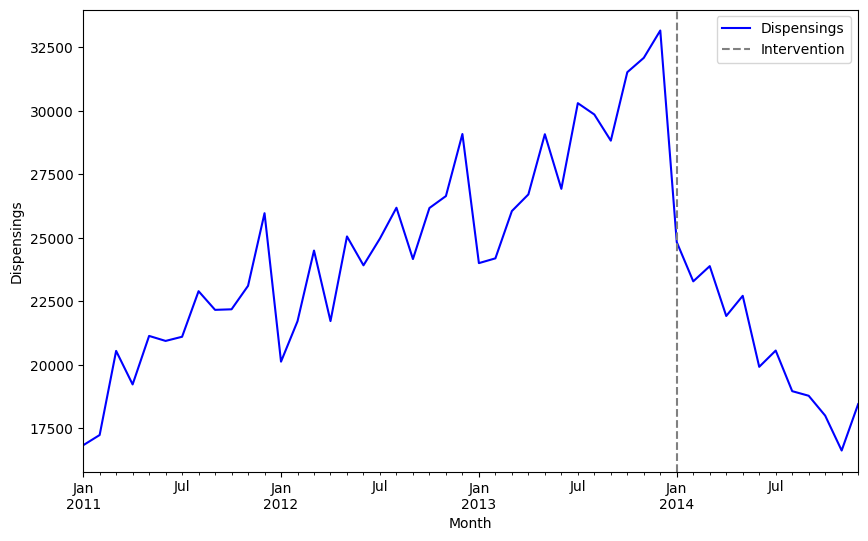

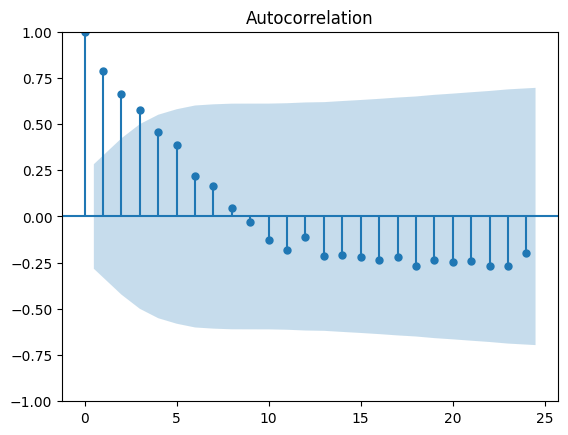

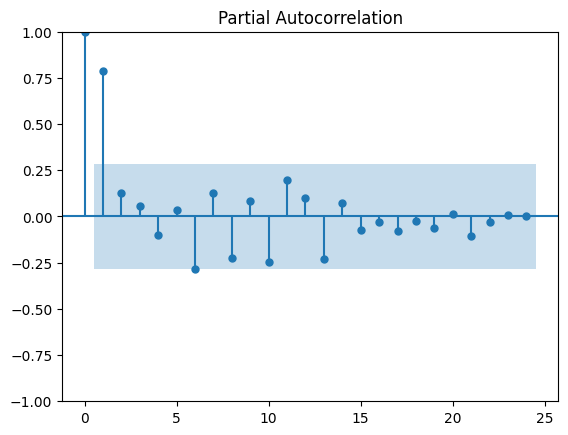

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


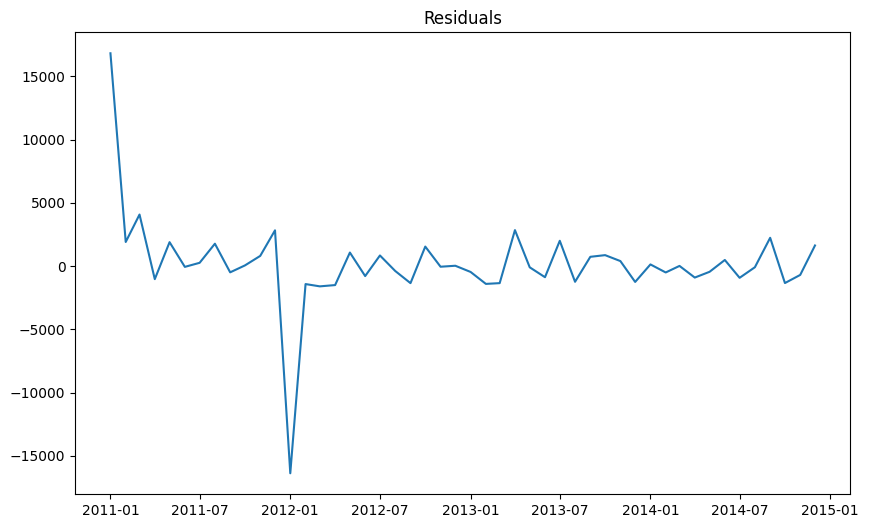

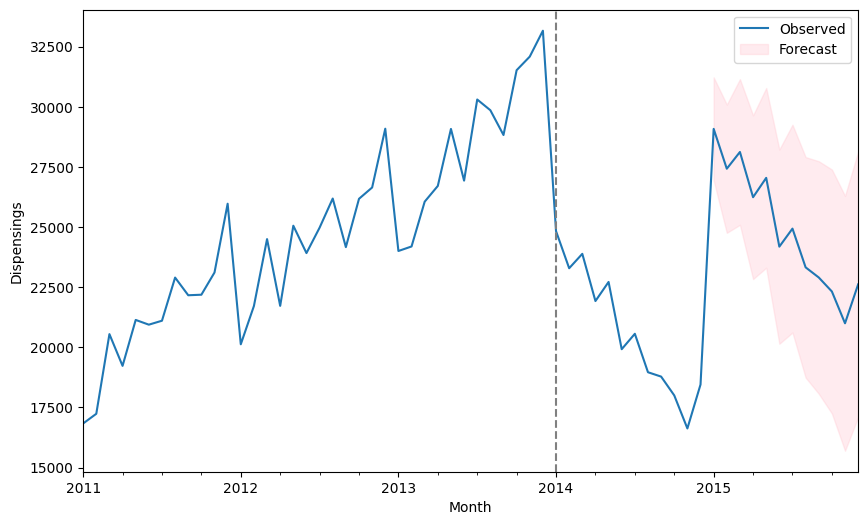

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

# Load data
quet = pd.read_csv('quet.csv', parse_dates=['month'], index_col='month')

# Convert data to time series
quet_ts = quet['dispensings'].asfreq('MS')

# Plot data
plt.figure(figsize=(10, 6))
quet_ts.plot(color='blue', label='Dispensings')
plt.axvline(pd.Timestamp('2014-01-01'), color='gray', linestyle='--', label='Intervention')
plt.xlabel('Month')
plt.ylabel('Dispensings')
plt.legend()
plt.show()

# ACF and PACF plots
plot_acf(quet_ts, lags=24)
plot_pacf(quet_ts, lags=24)
plt.show()

# Create step and ramp variables
quet['step'] = (quet.index >= '2014-01-01').astype(int)
quet['ramp'] = np.arange(len(quet))
quet.loc[quet.index < '2014-01-01', 'ramp'] = 0

# Fit the model
model = SARIMAX(quet_ts, order=(2, 1, 0), seasonal_order=(0, 1, 1, 12),
                exog=quet[['step', 'ramp']])
results = model.fit(disp=False)

# Check residuals
residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Forecasting
future_dates = [quet_ts.index[-1] + DateOffset(months=x) for x in range(1, 13)]
forecast = results.get_forecast(steps=12, exog=quet[['step', 'ramp']].iloc[-12:])
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Combine observed and forecasted data
combined = pd.concat([quet_ts, mean_forecast])
combined.plot(figsize=(10, 6))
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(pd.Timestamp('2014-01-01'), color='gray', linestyle='--', label='Intervention')
plt.xlabel('Month')
plt.ylabel('Dispensings')
plt.legend(['Observed', 'Forecast'])
plt.show()
